# Single Cell RNA-seq Data Analysis on Mice Brain Cells
*The notebook is inspired by the ML workshop tutorial created by the Krishnaswamy lab (https://www.krishnaswamylab.org/workshop)  

# Section 1: Loading and preprocessing the data

Overview:
1. Loading data from the Tabula Muris project  
2. Filtering
3. Normalization
4. Transformation

## 1. Install tools


In [1]:
!pip install scprep tasklogger

In [2]:
import pandas as pd
import numpy as np
import scprep

import matplotlib.pyplot as plt
%matplotlib inline

<a id='loading'></a>
## 2. Loading the mice brain data



### Mount Google Drive and use `scprep` to import data into Pandas DataFrames

Data files were downloaded from the Tabula Muris project
(https://www.czbiohub.org/tabula-muris/), which consist of myeloid and non-myeloid counts, annotations, and FACS metadata. All four files are in csv format.

In [3]:
import scprep

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data = scprep.io.load_csv("drive/MyDrive/290 Final_Project/Brain_Myeloid-counts.csv", cell_axis='column', sparse=True)
data.head()

,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B14Rik,0610009B22Rik,0610009D07Rik,0610009L18Rik,0610009O20Rik,0610010B08Rik,0610010F05Rik,0610010K14Rik,0610010O12Rik,0610011F06Rik,0610011L14Rik,0610012G03Rik,0610012H03Rik,0610030E20Rik,0610031J06Rik,0610031O16Rik,0610037L13Rik,0610037P05Rik,0610038B21Rik,0610038L08Rik,0610039K10Rik,0610040B10Rik,0610040F04Rik,0610040J01Rik,0610043K17Rik,0910001L09Rik,100043387,1100001G20Rik,1110001A16Rik,1110001J03Rik,1110002B05Rik,1110002L01Rik,...,Zranb3,Zrsr1,Zrsr2,Zscan10,Zscan12,Zscan18,Zscan2,Zscan20,Zscan21,Zscan22,Zscan29,Zscan4a,Zscan4b,Zscan4c,Zscan4d,Zscan4e,Zscan4f,Zscan5b,Zswim1,Zswim2,Zswim3,Zswim4,Zswim5,Zswim6,Zswim7,Zufsp,Zw10,Zwilch,Zwint,Zxda,Zxdb,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6,zsGreen_transgene
O5.MAA000570.3_8_M.1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,240.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,415.0,0.0,10.0,0.0,0.0,0.0,21.0,0.0,0.0,961.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,92.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,151.0,0.0,7.0,36.0,0.0,0.0,0.0
C3.MAA000570.3_8_M.1.1,0.0,348.0,0.0,0.0,0.0,686.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,174.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F17.MAA000570.3_8_M.1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,392.0,0.0,70.0,0.0,0.0,114.0,0.0,0.0,0.0,...,0.0,0.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I17.MAA000570.3_8_M.1.1,0.0,0.0,0.0,0.0,0.0,13.0,206.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,503.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,0.0,150.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,118.0,111.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,375.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
K17.MAA000570.3_8_M.1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,143.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The resulting dataframe contains the readout for different barcodes (row) and 23433 genes (columns)

# Checked and found no mitochondrial genes
Usually, this step is performed to filter out the dead cells whose mitochondrial level is high. This appears that the data itself is already prefiltered and all the cells are alive. 

In [6]:
data.loc[:, data.columns.str.startswith('MT')].columns

Index([], dtype='object')

### Load in non-myeloid data files

More complex single-cell datasets will often involve more than one file. In this section, we will load in the non-myeloid cell counts. 

In [7]:
# =============
# Give the first batch an appropriate name
first_batch_label = "Myeloid-counts" # Fill in the batch name, e.g. "Myeloid-counts"
# =============

data = [data]
batch_labels = [first_batch_label]

In [8]:
# =============
# Load your data with the appropriate `io` function
next_data = scprep.io.load_csv("drive/MyDrive/290 Final_Project/Brain_Non-Myeloid-counts.csv", cell_axis='column', sparse=True) # Fill in the batch name, e.g. "Non-myeloid-counts"
next_batch_label = "Non-Myeloid" # fill in the batch name, e.g. "Mutant"
# =============

data.append(next_data)
batch_labels.append(next_batch_label)

Save cell names to join with annotation dataframe later

In [9]:
cell_index = list(data[0].index)
nonmyeloid_index = list(data[1].index)
cell_index.extend(nonmyeloid_index)
len(cell_index)

10561

Now, we can combine our datasets into a single combined data matrix. There are 10561 cells in total and 23433 genes. 

In [10]:
data, sample_labels = scprep.utils.combine_batches(data, batch_labels)

In [11]:
print("Data shape:",data.shape)

Data shape: (10561, 23433)


In [12]:
data.head(10)

,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B14Rik,0610009B22Rik,0610009D07Rik,0610009L18Rik,0610009O20Rik,0610010B08Rik,0610010F05Rik,0610010K14Rik,0610010O12Rik,0610011F06Rik,0610011L14Rik,0610012G03Rik,0610012H03Rik,0610030E20Rik,0610031J06Rik,0610031O16Rik,0610037L13Rik,0610037P05Rik,0610038B21Rik,0610038L08Rik,0610039K10Rik,0610040B10Rik,0610040F04Rik,0610040J01Rik,0610043K17Rik,0910001L09Rik,100043387,1100001G20Rik,1110001A16Rik,1110001J03Rik,1110002B05Rik,1110002L01Rik,...,Zranb3,Zrsr1,Zrsr2,Zscan10,Zscan12,Zscan18,Zscan2,Zscan20,Zscan21,Zscan22,Zscan29,Zscan4a,Zscan4b,Zscan4c,Zscan4d,Zscan4e,Zscan4f,Zscan5b,Zswim1,Zswim2,Zswim3,Zswim4,Zswim5,Zswim6,Zswim7,Zufsp,Zw10,Zwilch,Zwint,Zxda,Zxdb,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6,zsGreen_transgene
O5.MAA000570.3_8_M.1.1_Myeloid-counts,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,240.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,415.0,0.0,10.0,0.0,0.0,0.0,21.0,0.0,0.0,961.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,92.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,151.0,0.0,7.0,36.0,0.0,0.0,0.0
C3.MAA000570.3_8_M.1.1_Myeloid-counts,0.0,348.0,0.0,0.0,0.0,686.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,174.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F17.MAA000570.3_8_M.1.1_Myeloid-counts,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,392.0,0.0,70.0,0.0,0.0,114.0,0.0,0.0,0.0,...,0.0,0.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I17.MAA000570.3_8_M.1.1_Myeloid-counts,0.0,0.0,0.0,0.0,0.0,13.0,206.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,503.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,0.0,150.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,118.0,111.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,375.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
K17.MAA000570.3_8_M.1.1_Myeloid-counts,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,143.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M12.MAA000570.3_8_M.1.1_Myeloid-counts,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,127.0,0.0,0.0,4.0,1.0,0.0,1.0,220.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,273.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,177.0,0.0,0.0,0.0,0.0,1.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,339.0,0.0,295.0,0.0,0.0,0.0
P16.MAA000570.3_8_M.1.1_Myeloid-counts,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,182.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,160.0,0.0,0.0,0.0,58.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,191.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C4.MAA000570.3_8_M.1.1_Myeloid-counts,0.0,652.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,328.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,498.0,11.0,7.0,0.0,0.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,219.0,0.0,0.0,0.0,0.0,0.0,0.0
F21.MAA000570.3_8_M.1.1_Myeloid-counts,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,155.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,330.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.

### Creating the metadata matrix

We are given a metadata file called annotation. In order to join the data dataframe and the annotation later, we need to make sure the cell IDs are saved as 'cell' as a key to join tables later.

,sample_labels,cell
O5.MAA000570.3_8_M.1.1_Myeloid-counts,Myeloid-counts,O5.MAA000570.3_8_M.1.1
C3.MAA000570.3_8_M.1.1_Myeloid-counts,Myeloid-counts,C3.MAA000570.3_8_M.1.1
F17.MAA000570.3_8_M.1.1_Myeloid-counts,Myeloid-counts,F17.MAA000570.3_8_M.1.1
I17.MAA000570.3_8_M.1.1_Myeloid-counts,Myeloid-counts,I17.MAA000570.3_8_M.1.1
K17.MAA000570.3_8_M.1.1_Myeloid-counts,Myeloid-counts,K17.MAA000570.3_8_M.1.1
...,...,...
P2.B003728.3_56_F.1.1_Non-Myeloid,Non-Myeloid,P2.B003728.3_56_F.1.1
P4.B003728.3_56_F.1.1_Non-Myeloid,Non-Myeloid,P4.B003728.3_56_F.1.1
P5.B003728.3_56_F.1.1_Non-Myeloid,Non-Myeloid,P5.B003728.3_56_F.1.1
P6.B003728.3_56_F.1.1_Non-Myeloid,Non-Myeloid,P6.B003728.3_56_F.1.1


### Library size filtering

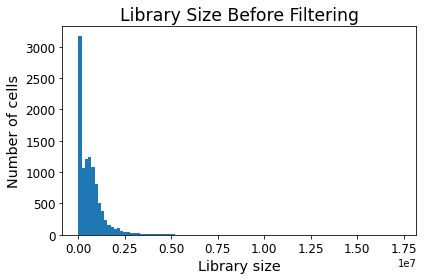

In [14]:
scprep.plot.plot_library_size(data,
                              log=False, title='Library Size Before Filtering')

Choose cutoffs above and below the main bulk of cells, removing cells that are both significantly smaller than average and significantly larger than average.

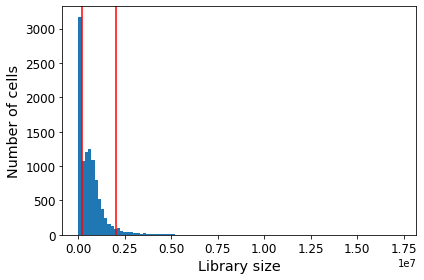

#### Selecting a cutoff

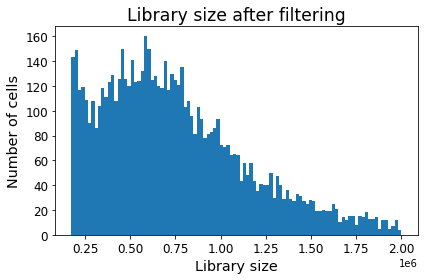

The library size distribution is now much more constrained, which will reduce the effects of differences in library size (which can affect your results, even after normalization).

### Subsampling data

Subsampling enables faster processing.

In [18]:
data, metadata = scprep.select.subsample(data, metadata, n=6863)

In [19]:
data.shape, metadata.shape

((6863, 23433), (6863, 2))

In [20]:
metadata = pd.DataFrame(metadata)
metadata

,sample_labels,cell
O5.MAA000570.3_8_M.1.1_Myeloid-counts,Myeloid-counts,O5.MAA000570.3_8_M.1.1
C3.MAA000570.3_8_M.1.1_Myeloid-counts,Myeloid-counts,C3.MAA000570.3_8_M.1.1
F17.MAA000570.3_8_M.1.1_Myeloid-counts,Myeloid-counts,F17.MAA000570.3_8_M.1.1
I17.MAA000570.3_8_M.1.1_Myeloid-counts,Myeloid-counts,I17.MAA000570.3_8_M.1.1
K17.MAA000570.3_8_M.1.1_Myeloid-counts,Myeloid-counts,K17.MAA000570.3_8_M.1.1
...,...,...
M20.B003728.3_56_F.1.1_Non-Myeloid,Non-Myeloid,M20.B003728.3_56_F.1.1
P14.B003728.3_56_F.1.1_Non-Myeloid,Non-Myeloid,P14.B003728.3_56_F.1.1
P20.B003728.3_56_F.1.1_Non-Myeloid,Non-Myeloid,P20.B003728.3_56_F.1.1
O19.B003728.3_56_F.1.1_Non-Myeloid,Non-Myeloid,O19.B003728.3_56_F.1.1


<a id='preprocessing'></a>
## 3. Preprocessing: Filtering, Normalizing, and Transforming

### Filtering

We filter the data by: 
1. Filtering by library size (done in prior section)
2. Removing genes that are expressed in relatively few cells.

### Filtering lowly expressed genes

Lowly expressed genes that may only be represented by a handful of mRNAs may not appear in a given dataset. Others might only be present in a small number of cells. Because we lack sufficient information about these genes, we remove lowly expressed genes from the gene expression matrix during preprocessing. Typically, if a gene is detected in fewer than very few cells, it gets removed.

/usr/local/lib/python3.7/dist-packages/scprep/plot/histogram.py:167: MatplotlibDeprecationWarning: SymmetricalLogScale got an unexpected keyword argument 'linthresh'. In the future this will raise TypeError
  ax.set_xscale("symlog", linthresh=abs_min)


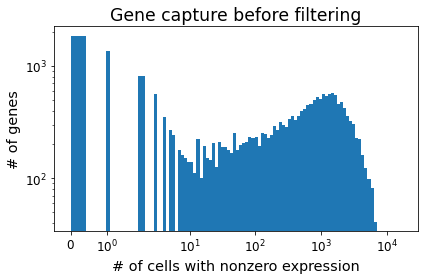

In [21]:
scprep.plot.histogram(scprep.measure.gene_capture_count(data), log=True,
                      title="Gene capture before filtering",
                     xlabel='# of cells with nonzero expression',
                     ylabel='# of genes')

### Determine the cutoff and filter the rare genes

/usr/local/lib/python3.7/dist-packages/scprep/plot/histogram.py:167: MatplotlibDeprecationWarning: SymmetricalLogScale got an unexpected keyword argument 'linthresh'. In the future this will raise TypeError
  ax.set_xscale("symlog", linthresh=abs_min)


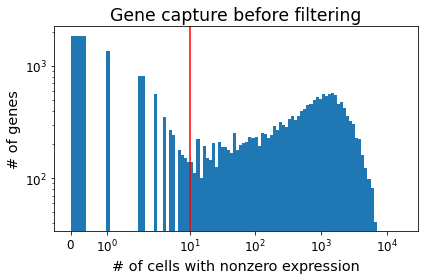

In [22]:
scprep.plot.histogram(scprep.measure.gene_capture_count(data), 
                      cutoff = 10,
                      log=True,
                      title="Gene capture before filtering",
                     xlabel='# of cells with nonzero expression',
                     ylabel='# of genes')


In [23]:
cutoff = 10
data = scprep.filter.filter_rare_genes(data, min_cells=cutoff)


Plot the above histogram again for good measure. The rare genes are all gone.

/usr/local/lib/python3.7/dist-packages/scprep/plot/histogram.py:167: MatplotlibDeprecationWarning: SymmetricalLogScale got an unexpected keyword argument 'linthresh'. In the future this will raise TypeError
  ax.set_xscale("symlog", linthresh=abs_min)


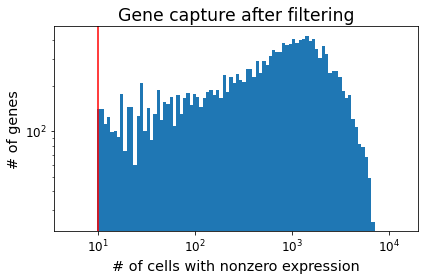

In [24]:
scprep.plot.histogram(scprep.measure.gene_capture_count(data), cutoff=cutoff, log=True,
                      title="Gene capture after filtering",
                     xlabel='# of cells with nonzero expression',
                     ylabel='# of genes')

In [25]:
data.shape

(6863, 17503)

After filtering, we have 6863 cells left.

### Normalization

The range of library sizes between cells can be quite extreme. We visualized this for one time point pre-filtering, but let's now visualize the whole dataset, post-filtering.

/usr/local/lib/python3.7/dist-packages/scprep/plot/histogram.py:167: MatplotlibDeprecationWarning: SymmetricalLogScale got an unexpected keyword argument 'linthresh'. In the future this will raise TypeError
  ax.set_xscale("symlog", linthresh=abs_min)


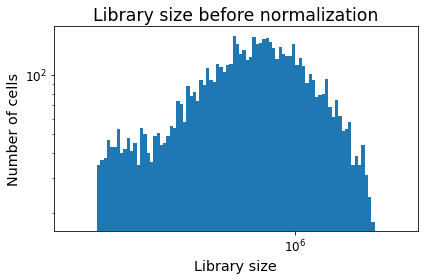

In [26]:
scprep.plot.plot_library_size(data, title='Library size before normalization')

To correct for differences in library sizes, we divide each cell by its library size and then rescale by the a fixed value, sometimes the median library size. The default in `scprep` is to rescale every cell to 10,000 counts to make numbers comparable across datasets.

In [27]:
data, metadata['library_size'] = scprep.normalize.library_size_normalize(data, return_library_size=True)

After plotting the library sizes again, the sizes are all the same now.

/usr/local/lib/python3.7/dist-packages/scprep/plot/histogram.py:167: MatplotlibDeprecationWarning: SymmetricalLogScale got an unexpected keyword argument 'linthresh'. In the future this will raise TypeError
  ax.set_xscale("symlog", linthresh=abs_min)


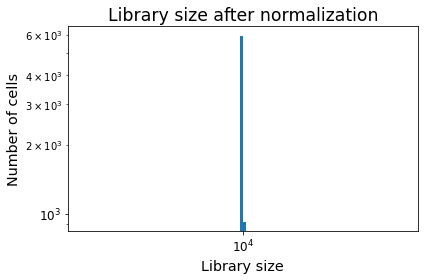

In [28]:
scprep.plot.plot_library_size(data, title='Library size after normalization')

### Gene Count Transformation

In scRNA-seq analysis, we often see that some genes are orders of magnitude more common than others.

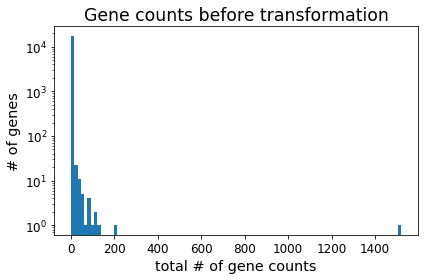

In [29]:
scprep.plot.histogram(data.mean(axis=0), log='y',
                      title="Gene counts before transformation",
                     xlabel='total # of gene counts',
                     ylabel='# of genes')

In order to avoid these high-expression genes dominating the variation, the data is often $\log$-transformed. 

In [30]:
data = scprep.transform.sqrt(data)

After transformation, you should see that the mean expression values are now much closer together.

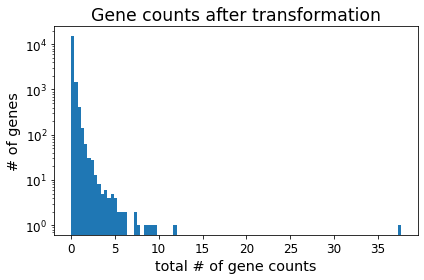

In [31]:
scprep.plot.histogram(data.mean(axis=0), log='y',
                      title="Gene counts after transformation",
                     xlabel='total # of gene counts',
                     ylabel='# of genes')

In [32]:
data.shape,metadata.shape

((6863, 17503), (6863, 3))

### [Optional] Save the output
Save the cleaned output now or proceed to the next section

In [33]:
data.to_pickle("data.pickle.gz")
metadata.to_pickle("metadata.pickle.gz")

,sample_labels,cell,library_size
O5.MAA000570.3_8_M.1.1_Myeloid-counts,Myeloid-counts,O5.MAA000570.3_8_M.1.1,732851.0
C3.MAA000570.3_8_M.1.1_Myeloid-counts,Myeloid-counts,C3.MAA000570.3_8_M.1.1,777301.0
F17.MAA000570.3_8_M.1.1_Myeloid-counts,Myeloid-counts,F17.MAA000570.3_8_M.1.1,553410.0
I17.MAA000570.3_8_M.1.1_Myeloid-counts,Myeloid-counts,I17.MAA000570.3_8_M.1.1,717128.0
K17.MAA000570.3_8_M.1.1_Myeloid-counts,Myeloid-counts,K17.MAA000570.3_8_M.1.1,479074.0
...,...,...,...
M20.B003728.3_56_F.1.1_Non-Myeloid,Non-Myeloid,M20.B003728.3_56_F.1.1,1012187.0
P14.B003728.3_56_F.1.1_Non-Myeloid,Non-Myeloid,P14.B003728.3_56_F.1.1,433811.0
P20.B003728.3_56_F.1.1_Non-Myeloid,Non-Myeloid,P20.B003728.3_56_F.1.1,293761.0
O19.B003728.3_56_F.1.1_Non-Myeloid,Non-Myeloid,O19.B003728.3_56_F.1.1,279674.0


# Section 2: Dimensionality reduction

Load in essential packages

In [35]:
!pip install scprep phate umap-learn

In [65]:
import phate
import umap
import scprep
import os
import seaborn as sns

# 1. Check data and metadata to see they are correctly saved

In [37]:
data

,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610009B22Rik,0610009D07Rik,0610009L18Rik,0610009O20Rik,0610010B08Rik,0610010F05Rik,0610010K14Rik,0610010O12Rik,0610011F06Rik,0610011L14Rik,0610012G03Rik,0610012H03Rik,0610030E20Rik,0610031J06Rik,0610037L13Rik,0610037P05Rik,0610038B21Rik,0610038L08Rik,0610039K10Rik,0610040B10Rik,0610040J01Rik,0610043K17Rik,0910001L09Rik,100043387,1100001G20Rik,1110001A16Rik,1110001J03Rik,1110002B05Rik,1110002L01Rik,1110002N22Rik,1110003E01Rik,1110004E09Rik,1110004F10Rik,...,Znhit3,Znhit6,Znrd1,Znrd1as,Znrf1,Znrf2,Znrf3,Zp3,Zp3r,Zpbp,Zranb1,Zranb2,Zranb3,Zrsr1,Zrsr2,Zscan12,Zscan18,Zscan2,Zscan20,Zscan21,Zscan22,Zscan29,Zswim1,Zswim3,Zswim4,Zswim5,Zswim6,Zswim7,Zufsp,Zw10,Zwilch,Zwint,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,l7Rn6
O5.MAA000570.3_8_M.1.1_Myeloid-counts,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,1.809663,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.379667,0.369396,0.000000,0.0,0.0,0.535306,0.0,3.621211,0.0,0.116813,0.000000,0.0,0.000000,0.0,0.000000,1.120433,2.210211,0.000000,0.000000,0.165199,...,0.0,0.0,0.000000,0.0,0.000000,0.00000,1.185525,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.330398,0.0,0.000000,0.0,0.0,0.0,0.0,0.495597,0.0,0.0,0.0,1.435425,0.000000,0.309059,0.70088,0.000000
C3.MAA000570.3_8_M.1.1_Myeloid-counts,0.0,2.115899,0.0,0.0,0.0,2.970759,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.392913,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.507248,0.0,0.000000,1.496167,0.000000,0.000000,0.000000,2.889534,...,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.641624,0.661371,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000
F17.MAA000570.3_8_M.1.1_Myeloid-counts,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.134424,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.987810,0.000000,0.0,0.0,0.000000,0.0,2.661457,0.0,1.124671,0.000000,0.0,1.435255,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.134424,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1.124671,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.134424,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000
I17.MAA000570.3_8_M.1.1_Myeloid-counts,0.0,0.000000,0.0,0.0,0.0,0.425768,1.694866,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.118087,0.000000,0.000000,0.000000,0.0,0.0,2.648413,0.000000,0.000000,0.0,0.0,0.000000,0.0,1.238506,0.0,1.446263,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.320251,...,0.0,0.0,0.000000,0.0,0.118087,0.26405,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.409065,0.0,0.0,0.0,0.0,1.282752,1.244123,0.0,0.0,0.0,0.000000,0.0,2.286743,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000
K17.MAA000570.3_8_M.1.1_Myeloid-counts,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.727694,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,1.031772,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.191388,0.000000,1.576058,...,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M20.B003728.3_56_F.1.1_Non-Myeloid,0.0,0.000000,0.0

In [38]:
metadata

,sample_labels,cell,library_size
O5.MAA000570.3_8_M.1.1_Myeloid-counts,Myeloid-counts,O5.MAA000570.3_8_M.1.1,732851.0
C3.MAA000570.3_8_M.1.1_Myeloid-counts,Myeloid-counts,C3.MAA000570.3_8_M.1.1,777301.0
F17.MAA000570.3_8_M.1.1_Myeloid-counts,Myeloid-counts,F17.MAA000570.3_8_M.1.1,553410.0
I17.MAA000570.3_8_M.1.1_Myeloid-counts,Myeloid-counts,I17.MAA000570.3_8_M.1.1,717128.0
K17.MAA000570.3_8_M.1.1_Myeloid-counts,Myeloid-counts,K17.MAA000570.3_8_M.1.1,479074.0
...,...,...,...
M20.B003728.3_56_F.1.1_Non-Myeloid,Non-Myeloid,M20.B003728.3_56_F.1.1,1012187.0
P14.B003728.3_56_F.1.1_Non-Myeloid,Non-Myeloid,P14.B003728.3_56_F.1.1,433811.0
P20.B003728.3_56_F.1.1_Non-Myeloid,Non-Myeloid,P20.B003728.3_56_F.1.1,293761.0
O19.B003728.3_56_F.1.1_Non-Myeloid,Non-Myeloid,O19.B003728.3_56_F.1.1,279674.0


# Load in annotation

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python3.7/dist-packages/scprep/io/utils.py:124: RuntimeWarning: Duplicate cell names detected! Some functions may not work as intended. You can fix this by running `scprep.sanitize.check_index(data)`.
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/scprep/sanitize.py:51: RuntimeWarning: Data is not numeric. Many scprep functions will not work.
  RuntimeWarning,


In [40]:
annotation=pd.DataFrame(annotation)
annotation = annotation.set_index('cell')
annotation.head()

,Neurog3>0_scaled,cell_ontology_class,cell_ontology_id,cluster.ids,free_annotation,mouse.id,mouse.sex,plate.barcode,subsetA,subsetA_cluster.ids,subsetB,subsetB_cluster.ids,subsetC,subsetC_cluster.ids,subsetD,subsetD_cluster.ids,subsetE,subsetE_cluster.ids,subtissue,tissue,tissue_tSNE_1,tissue_tSNE_2
cell,,,,,,,,,,,,,,,,,,,,,,
A1.B000610.3_56_F.1.1,NaN,bladder cell,CL:1001319,5,Bladder mesenchymal cell,3_56_F,F,B000610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bladder,-7.182841,-10.895094
A1.B002764.3_38_F.1.1,NaN,bladder urothelial cell,CL:1001428,3,Luminal bladder epithelial cell,3_38_F,F,B002764,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bladder,4.199059,-11.050240
A1.B002771.3_39_F.1.1,NaN,bladder cell,CL:1001319,5,Bladder mesenchymal cell,3_39_F,F,B002771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bladder,-11.995435,-7.325534
A1.D041914.3_8_M.1.1,NaN,bladder cell,CL:1001319,5,Bladder mesenchymal cell,3_8_M,M,D041914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bladder,-6.820022,-14.174246
A1.D042253.3_9_M.1.1,NaN,bladder cell,CL:1001319,2,Bladder mesenchymal cell,3_9_M,M,D042253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bladder,-24.163538,-7.499349


Metadata joins annotation and the new metadata will be for later use

In [41]:
metadata = metadata.join(annotation,on='cell')
metadata

,sample_labels,cell,library_size,Neurog3>0_scaled,cell_ontology_class,cell_ontology_id,cluster.ids,free_annotation,mouse.id,mouse.sex,plate.barcode,subsetA,subsetA_cluster.ids,subsetB,subsetB_cluster.ids,subsetC,subsetC_cluster.ids,subsetD,subsetD_cluster.ids,subsetE,subsetE_cluster.ids,subtissue,tissue,tissue_tSNE_1,tissue_tSNE_2
O5.MAA000570.3_8_M.1.1_Myeloid-counts,Myeloid-counts,O5.MAA000570.3_8_M.1.1,732851.0,NaN,microglial cell,CL:0000129,0.0,NaN,3_8_M,M,MAA000570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cerebellum,Brain_Myeloid,34.105089,-5.700181
C3.MAA000570.3_8_M.1.1_Myeloid-counts,Myeloid-counts,C3.MAA000570.3_8_M.1.1,777301.0,NaN,microglial cell,CL:0000129,3.0,NaN,3_8_M,M,MAA000570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cerebellum,Brain_Myeloid,-2.352823,-20.807033
F17.MAA000570.3_8_M.1.1_Myeloid-counts,Myeloid-counts,F17.MAA000570.3_8_M.1.1,553410.0,NaN,microglial cell,CL:0000129,3.0,NaN,3_8_M,M,MAA000570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cerebellum,Brain_Myeloid,1.799430,-29.492587
I17.MAA000570.3_8_M.1.1_Myeloid-counts,Myeloid-counts,I17.MAA000570.3_8_M.1.1,717128.0,NaN,microglial cell,CL:0000129,3.0,NaN,3_8_M,M,MAA000570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cerebellum,Brain_Myeloid,-2.511771,-15.194189
K17.MAA000570.3_8_M.1.1_Myeloid-counts,Myeloid-counts,K17.MAA000570.3_8_M.1.1,479074.0,NaN,microglial cell,CL:0000129,3.0,NaN,3_8_M,M,MAA000570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cerebellum,Brain_Myeloid,-3.705643,-28.084954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M20.B003728.3_56_F.1.1_Non-Myeloid,Non-Myeloid,M20.B003728.3_56_F.1.1,1012187.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P14.B003728.3_56_F.1.1_Non-Myeloid,Non-Myeloid,P14.B003728.3_56_F.1.1,433811.0,NaN,oligodendrocyte,CL:0000128,0.0,NaN,3_56_F,F,B003728,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Striatum,Brain_Non-Myeloid,-10.694144,-6.129862
P20.B003728.3_56_F.1.1_Non-Myeloid,Non-Myeloid,P20.B003728.3_56_F.1.1,293761.0,NaN,oligodendrocyte,CL:0000128,7.0,NaN,3_56_F,F,B003728,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Striatum,Brain_Non-Myeloid,2.449545,-0.501760
O19.B003728.3_56_F.1.1_Non-Myeloid,Non-Myeloid,O19.B003728.3_56_F.1.1,279674.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Check different cell types are preserved after the join

In [42]:
metadata['cell_ontology_class'].unique()

array(['microglial cell', 'macrophage', nan, 'Bergmann glial cell',
       'oligodendrocyte', 'neuron', 'astrocyte',
       'oligodendrocyte precursor cell', 'endothelial cell',
       'brain pericyte'], dtype=object)

## 2. Visualization using Principle Components Analysis (PCA)

Here we're going to use the simplest dimensionality reduction method first. We don't expect PCA to work well because the dataset is so complex, but it's a good place to start with any dataset.

#### Running PCA on the mice myeloid data

In [43]:
data_pca = scprep.reduce.pca(data, n_components=50, method='dense')

In [44]:
data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
O5.MAA000570.3_8_M.1.1_Myeloid-counts,-22.671789,-3.475618,-2.739016,0.691728,14.207593,-0.499162,1.146172,0.018481,0.644109,-0.411932,4.188203,1.615642,2.955335,-1.113317,-2.939613,0.037328,0.814623,-1.420294,-1.618410,2.194060,-0.650902,3.795905,-0.755091,-3.531175,-0.668968,-0.790477,4.427505,1.284994,-1.996052,1.786836,1.513432,0.116010,-1.018389,0.976322,1.013322,-5.153149,-0.445083,0.791169,0.756989,-0.868006,-0.945426,-0.012984,2.405289,1.205160,1.517450,1.159536,-3.008097,0.462350,-0.645700,-1.698308
C3.MAA000570.3_8_M.1.1_Myeloid-counts,-20.668441,-0.035642,0.437880,1.933089,11.635771,0.701414,2.044946,-1.087611,4.909004,-0.253948,4.600844,0.501434,1.138469,0.163480,-0.883219,2.896798,0.331514,-0.413793,-0.264581,0.778847,-1.343080,2.104766,0.909431,-1.284557,-1.236599,0.517956,-0.813240,0.292965,4.488524,1.640872,-1.399545,1.245695,-3.450836,-0.367705,0.182026,-1.147367,-0.400287,-2.949165,0.244546,-1.698620,-0.384953,-1.267044,0.096907,-3.638804,2.176382,-0.193848,-0.757471,1.470741,1.731413,-2.775014
F17.MAA000570.3_8_M.1.1_Myeloid-counts,-23.997583,2.786800,2.947996,-0.488949,9.620096,0.746908,4.354794,0.259540,6.818538,0.749304,-0.638730,1.010489,8.189099,4.717646,-3.141009,-0.759678,-0.485245,-2.195433,-1.396894,2.685835,-2.223103,2.223604,1.447656,0.201360,-2.459326,0.892914,1.266064,-1.790705,0.778302,0.945868,-1.167240,-2.589073,1.856024,3.535511,-0.616686,-2.603951,-0.108390,1.655309,0.521247,1.253700,-2.422281,3.677606,-0.084901,1.465770,0.090739,3.079874,-0.387887,1.632226,3.930356,0.047478
I17.MAA000570.3_8_M.1.1_Myeloid-counts,-19.476127,0.027210,-0.401761,1.723133,15.423502,0.984668,0.955482,0.077736,2.882879,0.764156,0.631259,2.101420,0.893222,0.645928,-0.386939,2.329285,-0.609668,-2.211268,0.287759,3.240039,-2.847996,-0.519655,-1.949472,-1.134513,-1.014817,3.376617,0.297646,-1.198418,-5.583331,2.910976,-1.358061,-1.919025,-0.311904,3.035840,-3.183693,-1.354539,0.422262,-1.348272,0.938558,2.101861,-1.245241,-0.159704,-1.367888,-1.039325,2.256691,2.336448,-4.271555,-0.305372,4.424499,-2.953830
K17.MAA000570.3_8_M.1.1_Myeloid-counts,-20.606874,4.011213,8.448297,-2.192473,5.063715,0.644064,6.395491,-1.574139,8.138941,0.062954,0.823660,-0.779976,1.759086,2.750450,-2.590621,0.100398,1.187982,-2.860972,-2.651782,-0.594209,-1.418045,1.793699,-0.446879,-1.784450,1.047134,-0.085459,2.924083,-1.761277,1.567118,-0.130743,-0.644028,-0.943871,-2.611025,5.619421,1.444519,1.857275,-1.247024,0.017483,-0.779567,1.170163,1.545166,1.888348,-4.365505,-1.308275,2.007459,-3.397129,-2.141273,1.370309,1.565023,2.731249


#### Plotting PCs using `scprep.plot`

Run on the sample_labels column in the metadata

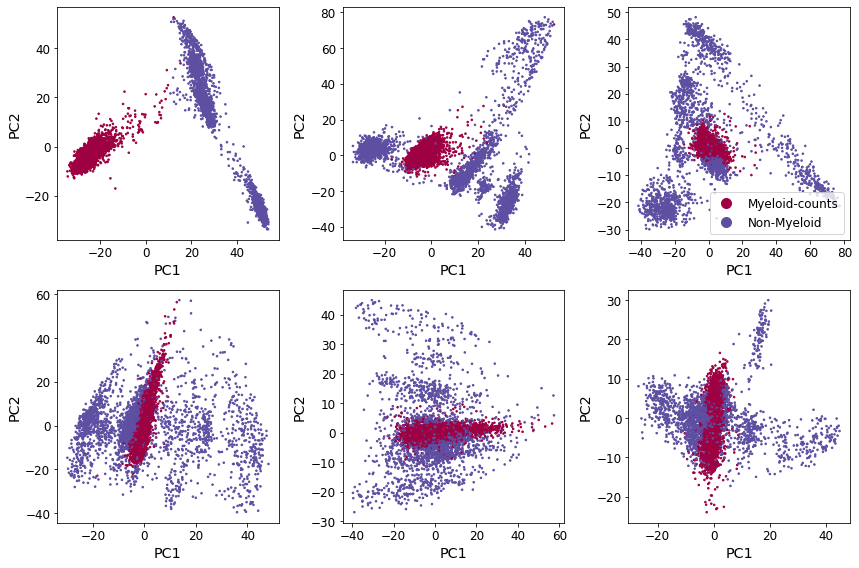

Run PCA again and change the labeling to the tissue column

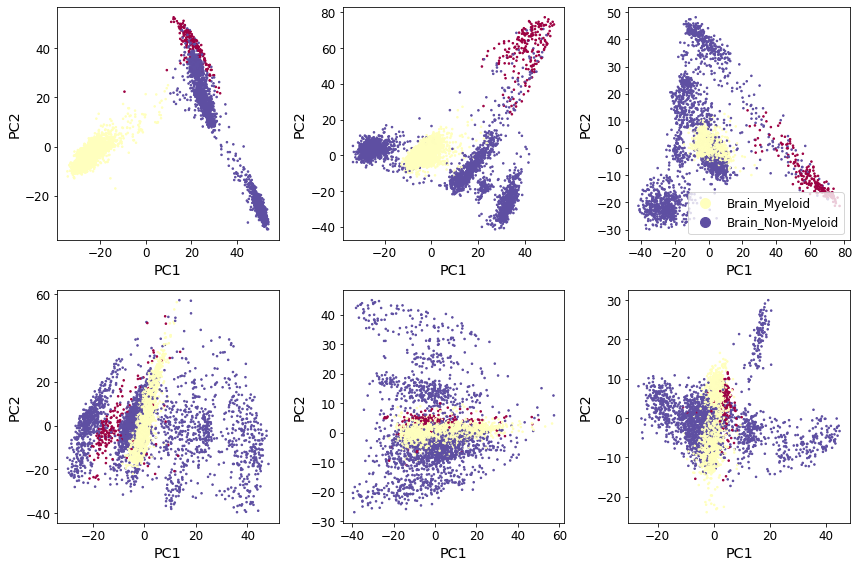

## 3. t-SNE

#### Running t-SNE on the myeloid data

tSNE is implemented in `scikit-learn`. t-SNE is a manifold learning algorithm.

We create a t-SNE operator and run it on data just like the PCA operator

```python
from sklearn.manifold import TSNE
tsne_op = TSNE(n_components=2, perplexity=30)
data_tsne = tsne_op.fit_transform(data)
```


Calculating tSNE on 6863 cells...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Calculated tSNE on 6863 cells in 53.64 seconds.


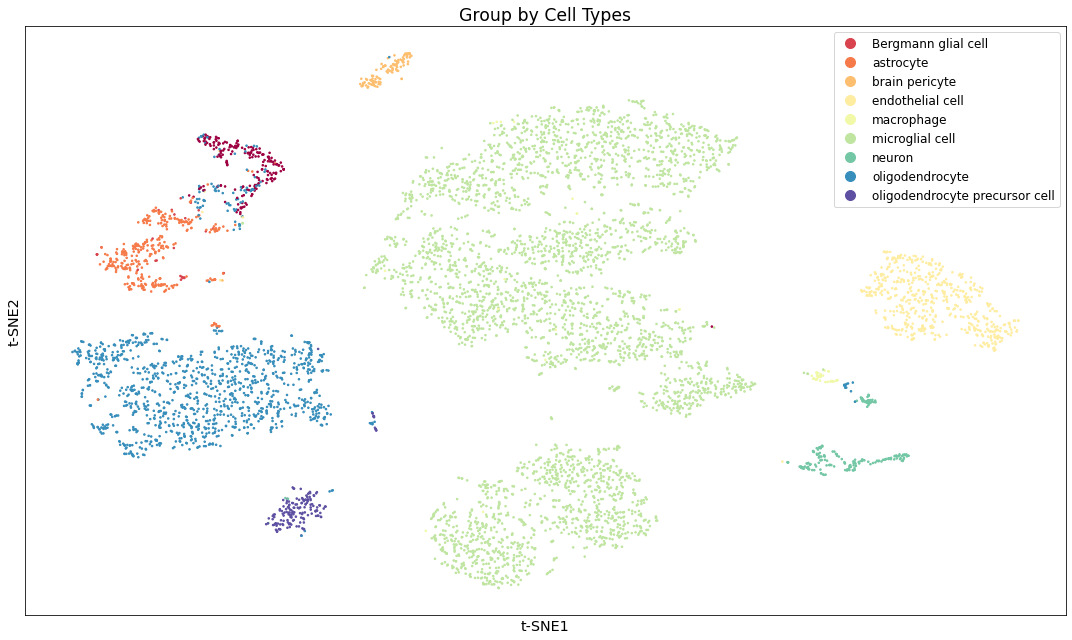

# Color clusters with 9 known mice marker genes 

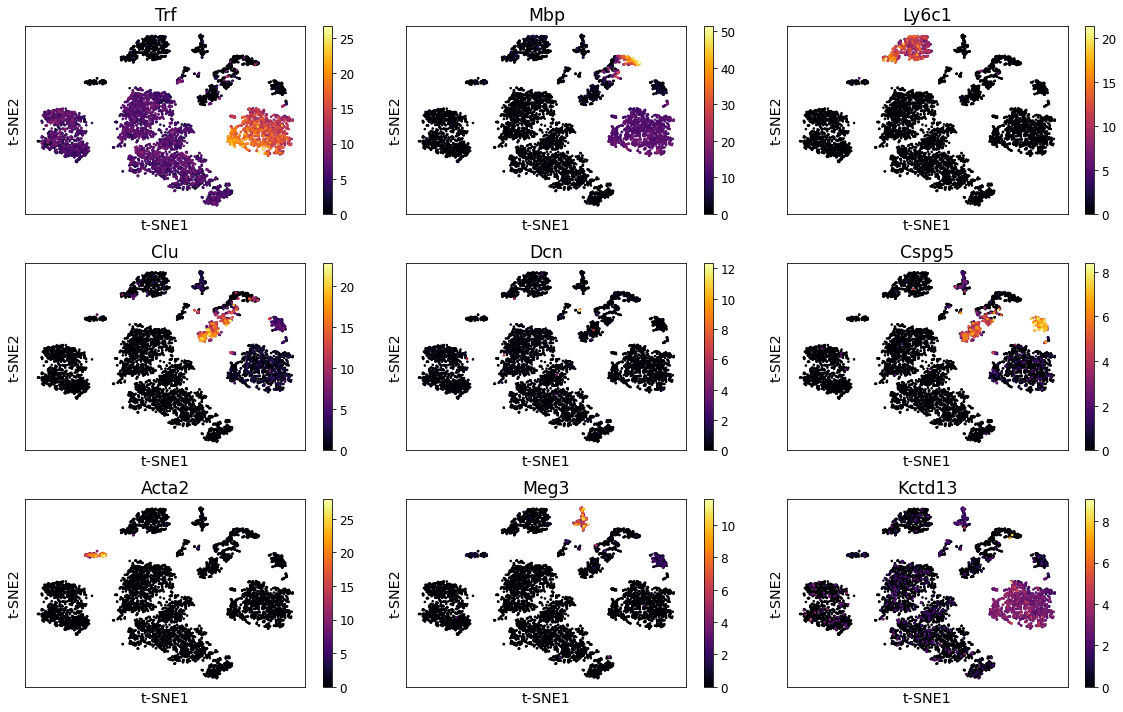

In [73]:
fig, axes = plt.subplots(3,3, figsize=(16,10))
axes = axes.flatten()

genes_for_plotting = ['Trf','Mbp','Ly6c1','Clu','Dcn','Cspg5','Acta2','Meg3','Kctd13']

for gene, ax in zip(genes_for_plotting, axes):
    expression = scprep.select.select_cols(data, exact_word=gene)
    
    sort_index = expression.sort_values().index
    
    scprep.plot.scatter2d(data_tsne.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                         title=gene, ticks=None, label_prefix='t-SNE', ax=ax)
    
fig.tight_layout()

# Section 3: Advanced clustering and differentially expressed genes identification

Load in essential packages

In [50]:
!pip install phate scprep umap-learn tasklogger magic-impute louvain seaborn
!pip install git+https://github.com/jacoblevine/phenograph.git

     |████████████████████████████████| 1.1 MB 5.1 MB/s 
     |████████████████████████████████| 3.2 MB 35.9 MB/s 
  Cloning https://github.com/jacoblevine/phenograph.git to /tmp/pip-req-build-fko2qakq
  Running command git clone -q https://github.com/jacoblevine/phenograph.git /tmp/pip-req-build-fko2qakq
  Created wheel for PhenoGraph: filename=PhenoGraph-1.5.2-py3-none-any.whl size=151757 sha256=7605c10dbdd8ee88de07ab8a7354311323bdbdf8f9a9f05b16a9709436b4708b
  Stored in directory: /tmp/pip-ephem-wheel-cache-61_tvg6k/wheels/54/8c/ad/a491f633a785f68feb00a65ca800f07a0bcb719f74003a0853
Successfully built PhenoGraph


In [51]:
import sklearn
import sklearn.cluster
import sklearn.manifold
import graphtools as gt
import magic
import phenograph
import louvain

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.
  import sys


# 1. Visualizing the data

Calculating tSNE on 6863 cells...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Calculated tSNE on 6863 cells in 75.03 seconds.


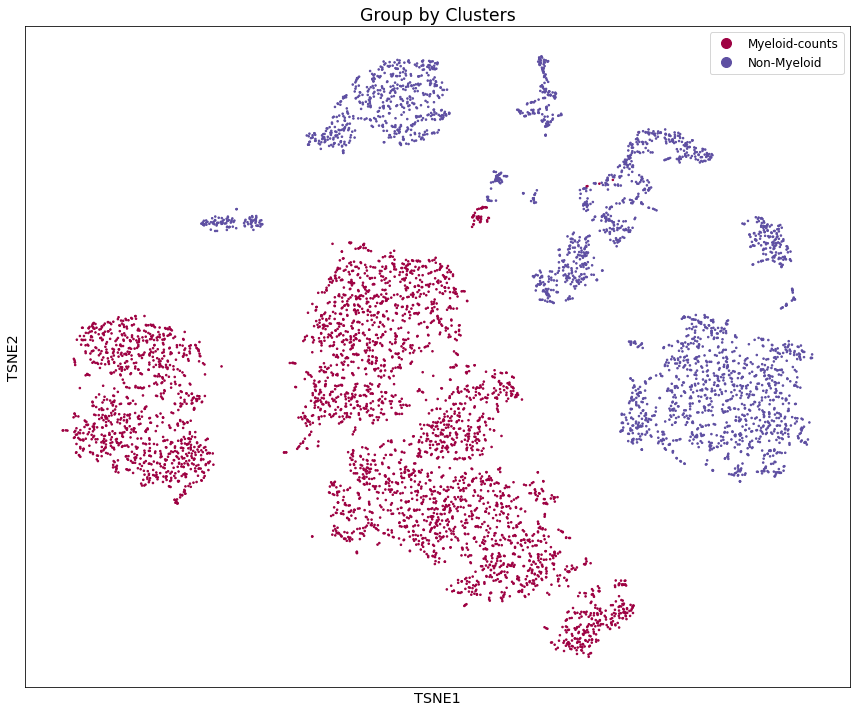

In [53]:
scprep.plot.scatter2d(data_tsne, c=metadata['sample_labels'], figsize=(12,10), cmap="Spectral",
                      ticks=False, label_prefix="TSNE", title= 'Group by Clusters')

# 2. Clustering

Create 20 clusters

In [54]:
phenograph_clusters, _, _ = phenograph.cluster(data_pca)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 3.3965625762939453 seconds
Jaccard graph constructed in 5.458246469497681 seconds
Wrote graph to binary file in 2.3637502193450928 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.896535
Louvain completed 21 runs in 7.700411558151245 seconds
PhenoGraph complete in 19.059421062469482 seconds


In [55]:
with tasklogger.log_task("KMeans"):
    kmeans_clusters = sklearn.cluster.KMeans(n_clusters=20).fit_predict(data_pca)

Calculating KMeans...
Calculated KMeans in 5.72 seconds.


In [56]:
G = gt.Graph(data_pca)
G_igraph = G.to_igraph()

In [57]:
with tasklogger.log_task("Louvain"):
    partition = louvain.find_partition(G_igraph, louvain.RBConfigurationVertexPartition, 
                                       weights="weight", resolution_parameter=1)
    louvain_clusters = np.array(partition.membership)

Calculating Louvain...
Calculated Louvain in 2.20 seconds.


In [58]:
with tasklogger.log_task("Spectral clustering"):
    spec_op = sklearn.cluster.SpectralClustering(n_clusters=20, affinity='precomputed')
    spectral_clusters = spec_op.fit_predict(G.K)

Calculating Spectral clustering...
Calculated Spectral clustering in 12.56 seconds.


## Clustering single cell data

#### Clustering methods for single cell RNA-seq

In the previous section, we compared three popular algorithms for clustering: KMeans, Spectral Clustering, and Louvain.

#### Reordering clusters by TSNE coordinates

By default, cluster numbers are meaningless. This makes it difficult to compare clusterings, because cluster "0" can refer to entirely different cells between runs of the same algorithm.

To enforce some consistency, we are going to reorder the clusters so that cluster "0" is always on the far right of the TSNE plot, and the highest-numbered cluster is always on the far left.

#### Plotting clusters with TSNE

Above, we colored our scatter plots using expression of a marker gene. However, we can use any information with one value per cell to color the plot. Here, we're using the cluster identity.

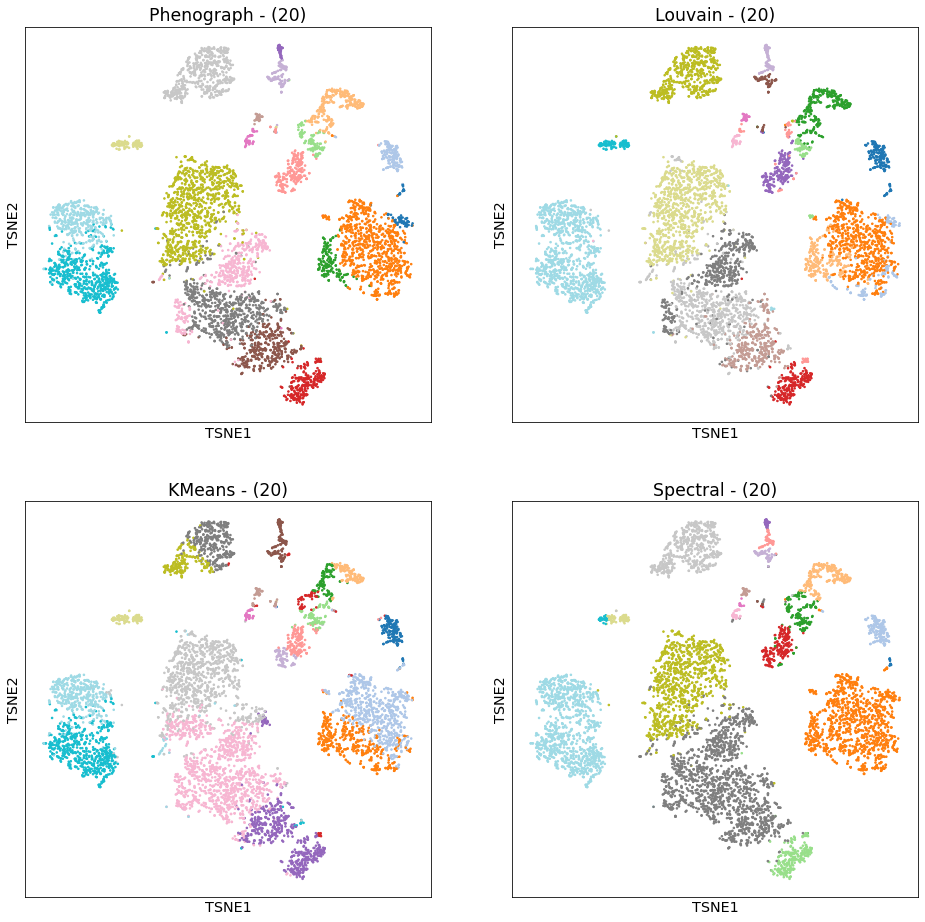

We can also plot each cluster individually to see where they are on the TSNE plot

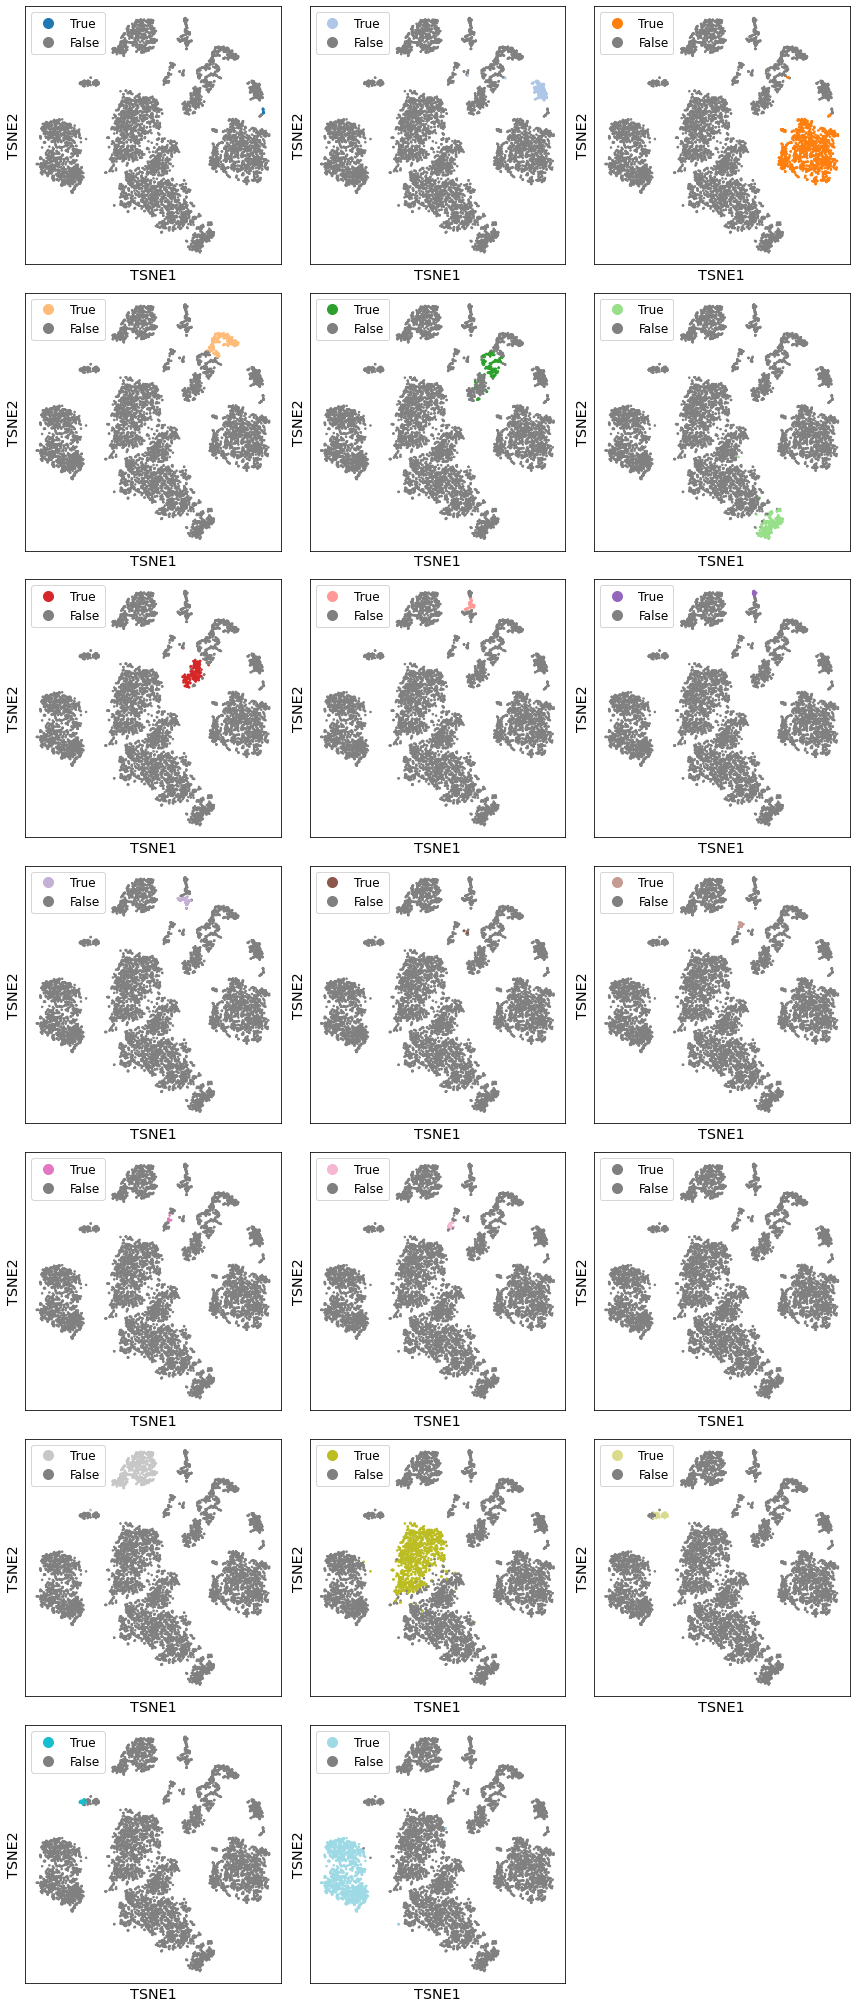

#### Grouping all of the cluster vectors into a single array

#### Plot a clustermap of distances

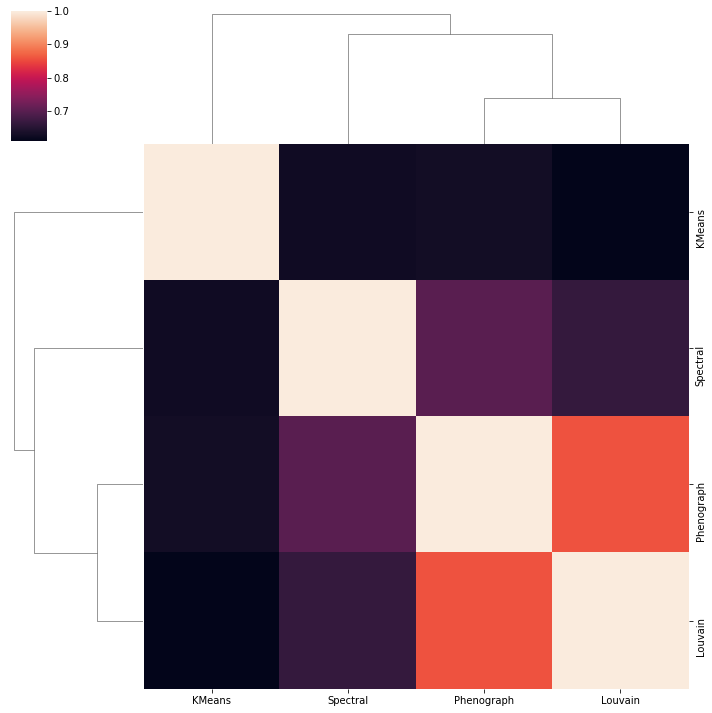

In [66]:
sns.clustermap(cluster_similarities, xticklabels=all_algorithms, yticklabels=all_algorithms)

In [67]:
# ==============
# choose your favorite clustering method from 'Phenograph', 'Louvain', 'KMeans', 'Spectral'
clusters = clusterings[ 'Spectral' ]
# ==============

# 3. Differential expression

In this section, we are going to identify the genes that change the most between two groups.

Created a function make_top_gene that takes in the number of top genes that we want to show from all 20 clusters, and return a dataframe to us


In [68]:
data_sparse = scprep.utils.SparseDataFrame(data)

In [70]:
df = make_top_gene(12)
df

Calculating t-test...
Calculated t-test in 44.86 seconds.
Calculating t-test...
Calculated t-test in 46.03 seconds.
Calculating t-test...
Calculated t-test in 42.34 seconds.
Calculating t-test...
Calculated t-test in 44.52 seconds.
Calculating t-test...
Calculated t-test in 45.30 seconds.
Calculating t-test...
Calculated t-test in 45.09 seconds.
Calculating t-test...
Calculated t-test in 45.59 seconds.
Calculating t-test...
Calculated t-test in 44.60 seconds.
Calculating t-test...
Calculated t-test in 44.40 seconds.
Calculating t-test...
Calculated t-test in 45.82 seconds.
Calculating t-test...
Calculated t-test in 46.12 seconds.
Calculating t-test...
Calculated t-test in 48.58 seconds.
Calculating t-test...
Calculated t-test in 46.93 seconds.
Calculating t-test...
Calculated t-test in 46.10 seconds.
Calculating t-test...
Calculated t-test in 43.60 seconds.
Calculating t-test...
Calculated t-test in 43.35 seconds.
Calculating t-test...
Calculated t-test in 43.72 seconds.
Calculating t-

,ttest
Sepp1,128.545155
C1qa,94.988612
C1qb,92.113132
C1qc,90.797146
Ctss,90.656354
...,...
Arglu1,53.194442
Ptn,51.460836
Prnp,50.506622
Laptm5,50.388345


According to this top gene dataframe, tabulate the most frequently occurred differentially expressed genes, and choose the top 12

C1qc       15
Tmem119    14
C1qb       14
P2ry12     13
Ctss       13
C1qa       13
Selplg     13
Laptm5     12
Cx3cr1      8
Sepp1       6
Hexb        5
F11r        4
dtype: int64

#### Print the 12 most differentially expressed genes 

Top 12 Gene visualization

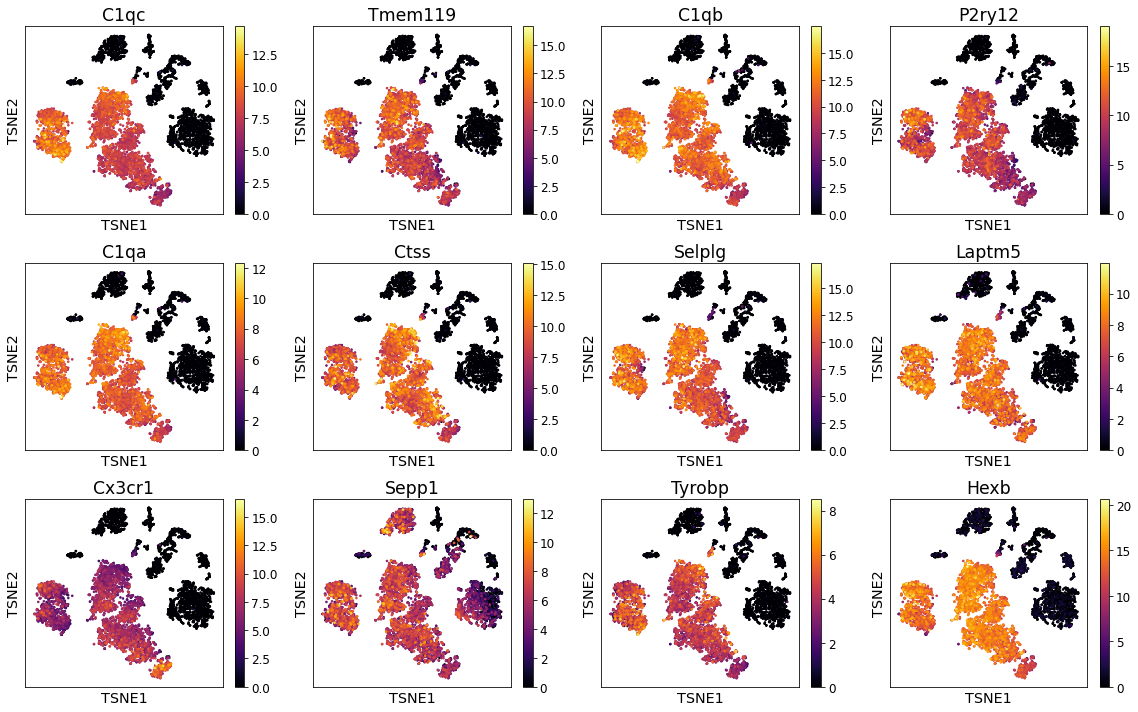